In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F 

import utils.tavr_torch as tavr_torch
from utils.tavr_torch import TAVR_3_Frame, TAVR_1_Frame, TAVR_Sequence, tavr_dataloader
from utils.visualization import display_grid, z_stretch, visualize_frame, set_figsize, get_central_slices
from utils.loss_functions import batch_l2_loss
from utils.run_model import train, test
from Models.basic_models import average_model, two_layer_basic, post_process

set_figsize(20, 15)

Training directory found, 36 series
Validation directory found, 6 series
Testing directory found, 10 series


In [2]:
USE_GPU = True
dtype = torch.float32 # we will be using float throughout this tutorial
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('using device:', device)

# "Pixl", "Slice", or "None"
preproc_type = "pixel"

validation = TAVR_3_Frame("__valid", preproc=preproc_type)
val_loader = tavr_dataloader(validation, batch_size=4, shuffle=True, num_workers=2)
training = TAVR_3_Frame("__train", preproc=preproc_type)
train_loader = tavr_dataloader(training,batch_size=8, shuffle=True, num_workers=2)


ave_model = average_model()
model = two_layer_basic()
post_proc = post_process(kind=preproc_type).to(device=device)
loss_fn = batch_l2_loss()

using device: cpu


In [3]:
learning_rate = 3e-3
momentum = 0.90
reg = 1e-7

optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=reg, nesterov=True)

In [4]:
train(model, post_proc, optimizer, train_loader, val_loader, loss_fn, device, 
         epochs=3, print_every=30, print_level=3, lr_decay=0.8)


****Epoch 0 Iteration 0, loss = 0.7466, corrected loss = 314.3503
Validation loss 294.9502 over 81 frames
conv_a1.weight,   	norm: 3.5343e+00, 	update norm: 9.2989e-03 	Update/norm: 2.6311e-03
conv_a1.bias,   	norm: 2.9005e-01, 	update norm: 1.4486e-03 	Update/norm: 4.9943e-03
conv_b1.weight,   	norm: 3.8095e+00, 	update norm: 1.0525e-02 	Update/norm: 2.7629e-03
conv_b1.bias,   	norm: 2.6428e-01, 	update norm: 1.5556e-03 	Update/norm: 5.8863e-03
final.weight,   	norm: 1.2712e+00, 	update norm: 1.4584e-02 	Update/norm: 1.1472e-02
final.bias,   	norm: 1.0691e-01, 	update norm: 1.2171e-03 	Update/norm: 1.1384e-02

Iter 0... ... ... 
Iter 10... ... ... 
Iter 20... ... ... 
Iteration 30, loss = 0.2488, corrected loss = 114.4093
Validation loss 108.5622 over 81 frames
conv_a1.weight,   	norm: 3.5238e+00, 	update norm: 4.5454e-03 	Update/norm: 1.2899e-03
conv_a1.bias,   	norm: 2.9793e-01, 	update norm: 6.9904e-04 	Update/norm: 2.3463e-03
conv_b1.weight,   	norm: 3.7923e+00, 	update norm: 4.6

Validation loss 68.1205 over 81 frames
Validation loss 36.7785 over 81 frames


/home/shared/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


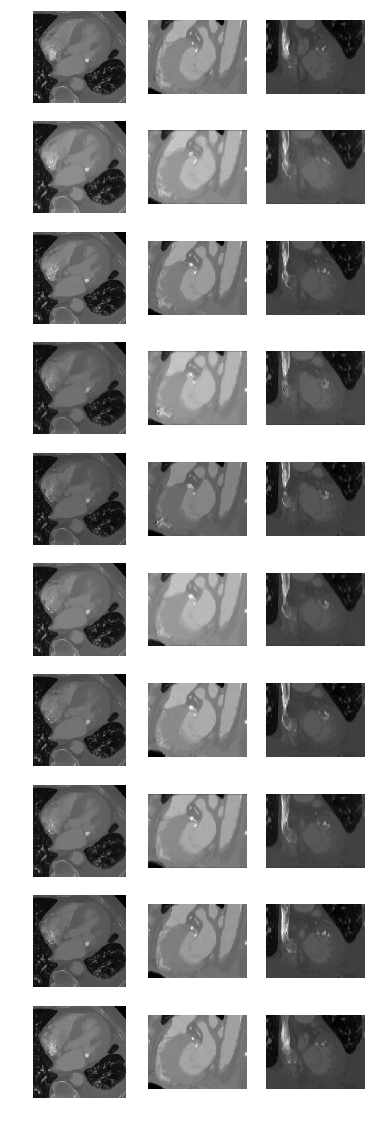

In [6]:
# One last test + visualize results on 1 validation sequence
val_seq = TAVR_Sequence("__valid")
test(model, post_proc, val_loader, loss_fn, device)
test(ave_model, post_proc, val_loader, loss_fn, device)

with torch.no_grad():
    model.eval()
    ave_frames = [val_seq[0][0]]
    for i in range(2,9,2):
        ave_frame = model((val_seq[0][i-2][None,:], val_seq[0][i][None,:]))
        ave_frames += [ave_frame[0][0],  val_seq[0][i]]
    ave_frames += [val_seq[0][9]]
    ave_frames_slices = []
    for f in ave_frames:
        ave_frames_slices += get_central_slices(f)
    set_figsize(6,20)
    display_grid(10, 3, ave_frames_slices)

In [ ]:
optimizer.param_groups[0]['lr']

In [ ]:
for p in model.parameters():
    print(p.norm())